<a href="https://colab.research.google.com/github/shin0105/4YP/blob/master/UCI_dataset_classification_car_withplots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install GPyOpt
!pip install GPy

In [2]:
#import packages

#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

#Bayesian optimization packages
import GPy
import GPyOpt

#ML Algorithm packages
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing

In [4]:
with open("car.names") as f:
    print(f.read())

1. Title: Car Evaluation Database

2. Sources:
   (a) Creator: Marko Bohanec
   (b) Donors: Marko Bohanec   (marko.bohanec@ijs.si)
               Blaz Zupan      (blaz.zupan@ijs.si)
   (c) Date: June, 1997

3. Past Usage:

   The hierarchical decision model, from which this dataset is
   derived, was first presented in 

   M. Bohanec and V. Rajkovic: Knowledge acquisition and explanation for
   multi-attribute decision making. In 8th Intl Workshop on Expert
   Systems and their Applications, Avignon, France. pages 59-78, 1988.

   Within machine-learning, this dataset was used for the evaluation
   of HINT (Hierarchy INduction Tool), which was proved to be able to
   completely reconstruct the original hierarchical model. This,
   together with a comparison with C4.5, is presented in

   B. Zupan, M. Bohanec, I. Bratko, J. Demsar: Machine learning by
   function decomposition. ICML-97, Nashville, TN. 1997 (to appear)

4. Relevant Information Paragraph:

   Car Evaluation Database was 

In [3]:
#dataset = UCI Car Evaluation
names=['buying','maint','doors','persons','lug_boot','safety','class']
df = pd.read_csv('car.data', names = names)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [6]:
#frequency distribution
for col in names: 
    print(df[col].value_counts())

#checking missing values
df.isnull().sum()

vhigh    432
high     432
med      432
low      432
Name: buying, dtype: int64
vhigh    432
high     432
med      432
low      432
Name: maint, dtype: int64
2        432
3        432
4        432
5more    432
Name: doors, dtype: int64
2       576
4       576
more    576
Name: persons, dtype: int64
small    576
med      576
big      576
Name: lug_boot, dtype: int64
low     576
med     576
high    576
Name: safety, dtype: int64
unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64


buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

In [4]:
#Convert categorical labels to numbers
le = preprocessing.LabelEncoder()

for col in names: 
  df[col] = le.fit_transform(df[col])

df.head()
for col in names: 
    print(df[col].value_counts())

3    432
0    432
2    432
1    432
Name: buying, dtype: int64
3    432
0    432
2    432
1    432
Name: maint, dtype: int64
0    432
1    432
2    432
3    432
Name: doors, dtype: int64
0    576
1    576
2    576
Name: persons, dtype: int64
2    576
1    576
0    576
Name: lug_boot, dtype: int64
1    576
2    576
0    576
Name: safety, dtype: int64
2    1210
0     384
1      69
3      65
Name: class, dtype: int64


In [5]:
X = df.drop(['class'], axis=1)
y = df['class']

#splitting train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [6]:
#K-fold validation
def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = KFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)
    return np.array(accuracy_list).mean()

In [7]:
#Random Forest classification

#max_features: 1 to around sqrt(# of features of dataset)
bounds = [
        {'name': 'max_features', 'type': 'continuous', 'domain': (1, 5)},
        {'name': 'n_estimators', 'type': 'continuous', 'domain': (1, 200)}
      ]

rf1_max_features=[]
rf1_n_estimators=[]
rf1_score=[]

def rf_score(parameters):
  params = {
        'max_features':int(parameters[0][0]),
        'n_estimators':int(parameters[0][1])
    }
  
  clf = RandomForestClassifier(max_features=params['max_features'],n_estimators=params['n_estimators'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)

  #storing results
  rf1_max_features.append(params['max_features'])
  rf1_n_estimators.append(params['n_estimators'])
  rf1_score.append(score)
  return score

In [14]:
#RF Classification - Matern52 kernel
kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

-0.9818112947658403
[  3.52180922 185.03659015]


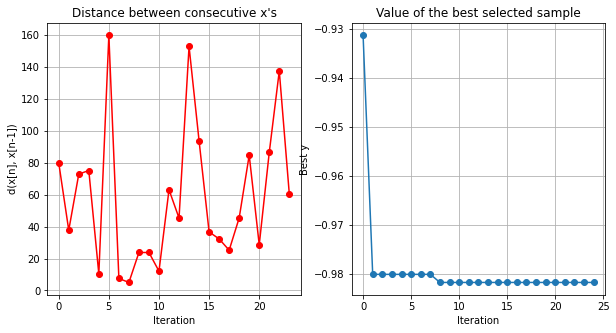

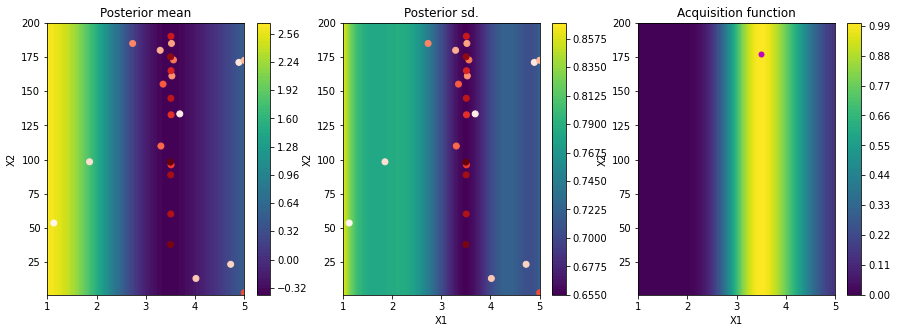

In [15]:
optimizer.plot_convergence()
optimizer.plot_acquisition()

In [12]:
#plot function
def plot(x1,x2,y,x1_name,x2_name,y_name):
  fig, ax = plt.subplots(1, 2, figsize=(18, 6))
  ax[0].scatter(x1,y)
  ax[0].set_xlabel(x1_name)
  ax[0].set_ylabel(y_name)
  ax[1].scatter(x2,y)
  ax[1].set_xlabel(x2_name)
  ax[1].set_ylabel(y_name)

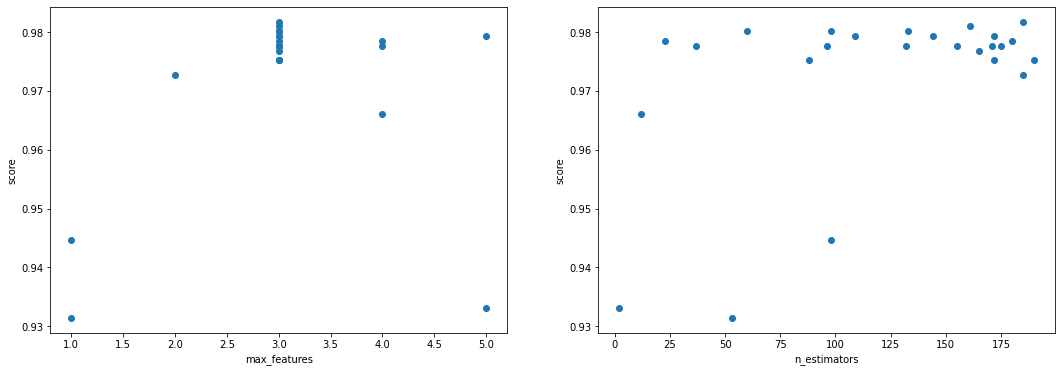

In [31]:
#2-D plot against hyperparameters-score
plot(rf1_max_features,rf1_n_estimators,rf1_score,'max_features','n_estimators','score')

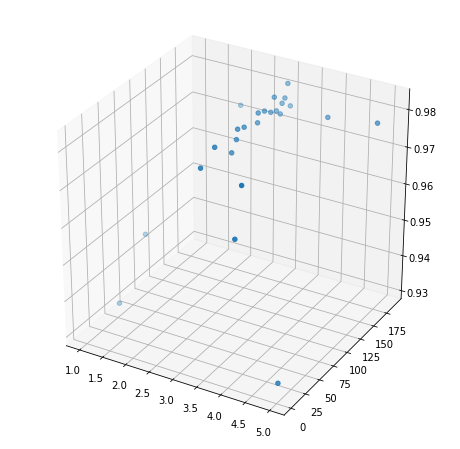

In [33]:
#3-D plot of hyperparameters-score
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.scatter(rf1_max_features, rf1_n_estimators, rf1_score)
plt.show()

In [ ]:
rf_car = RandomForestClassifier(max_features=4,n_estimators=93)
rf_car.fit(X_train,y_train)
y_pred = rf_car.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9730250481695568


{'max_features': 4, 'n_estimators': 27}
0.9785055096418732
{'max_features': 4, 'n_estimators': 104}
0.9809848484848486
{'max_features': 4, 'n_estimators': 125}
0.9809848484848486
{'max_features': 4, 'n_estimators': 45}
0.9801515151515151
{'max_features': 3, 'n_estimators': 138}
0.9751997245179064
{'max_features': 1, 'n_estimators': 32}
0.9255922865013775
{'max_features': 5, 'n_estimators': 37}
0.97849173553719
{'max_features': 4, 'n_estimators': 144}
0.9793319559228651
{'max_features': 4, 'n_estimators': 28}
0.9776790633608815
{'max_features': 4, 'n_estimators': 73}
0.9785055096418734
{'max_features': 4, 'n_estimators': 3}
0.95534435261708
{'max_features': 4, 'n_estimators': 111}
0.9768526170798898
{'max_features': 4, 'n_estimators': 178}
0.9801584022038569
{'max_features': 4, 'n_estimators': 24}
0.9710674931129477
{'max_features': 4, 'n_estimators': 67}
0.9809848484848486
{'max_features': 5, 'n_estimators': 98}
0.9776790633608817
{'max_features': 5, 'n_estimators': 66}
0.9826308539944

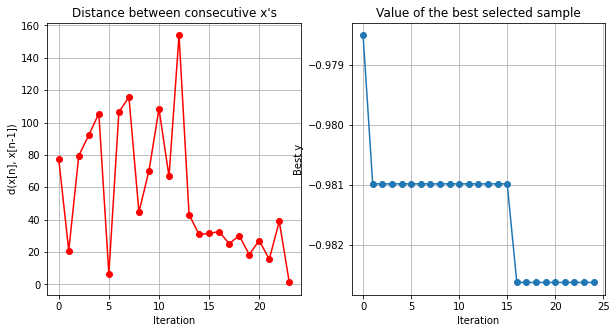

In [ ]:
#RF classification - Matern52 + ExpQuad
kernel2 = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0) + GPy.kern.ExpQuad(input_dim=1,variance=1.0,lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel2
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

optimizer.plot_convergence()

In [ ]:
rf_car2 = RandomForestClassifier(max_features=5,n_estimators=66)
rf_car2.fit(X_train,y_train)
y_pred = rf_car2.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9710982658959537


In [28]:
#SVM Classification

bounds = [ {'name': 'C', 'type': 'continuous', 'domain': (0.1, 100)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0.001, 1)}
      ]

SVM1_C=[]
SVM1_g=[]
SVM1_score=[]

def svm_score(parameters):
  params = {
        'C': parameters[0][0],
        'gamma':parameters[0][1]
    }
  
  clf = svm.SVC(C=params['C'],gamma=params['gamma'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)

  SVM1_C.append(params['C'])
  SVM1_g.append(params['gamma'])
  SVM1_score.append(score)

  return score

In [29]:
#SVM Classification - Matern52 kernel
kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=svm_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

-0.9859504132231406
[70.8309983  0.2143654]


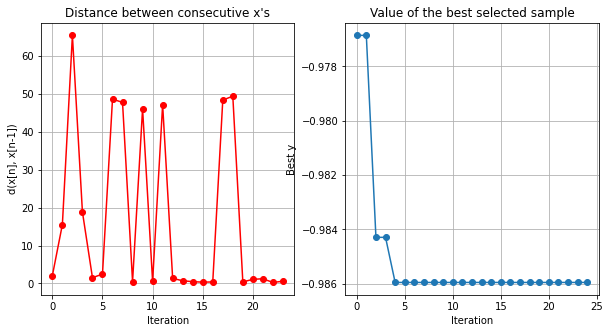

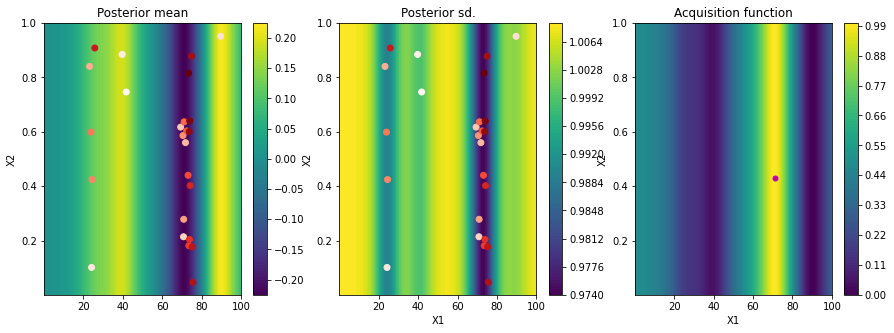

In [30]:
optimizer.plot_convergence()
optimizer.plot_acquisition()

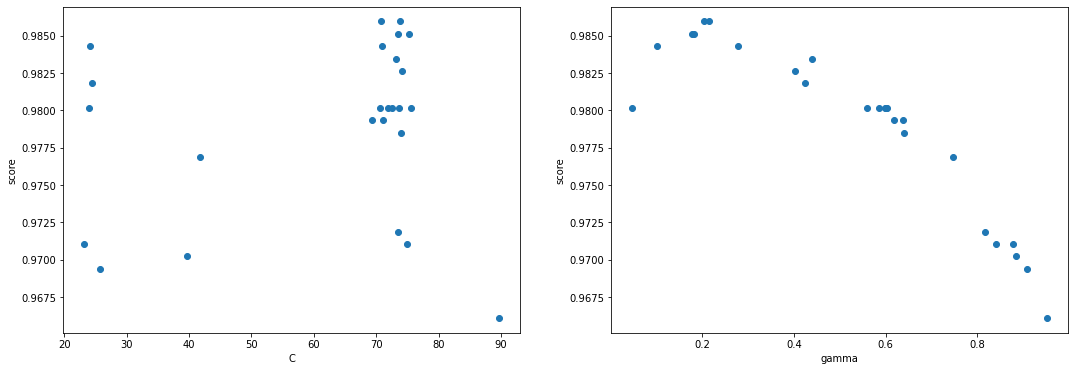

In [31]:
plot(SVM1_C,SVM1_g,SVM1_score,'C','gamma','score')

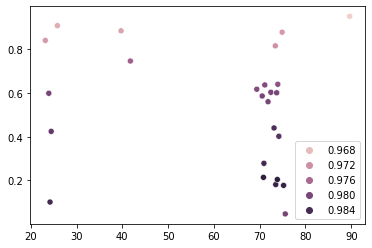

In [33]:
sns.scatterplot(x=SVM1_C,y=SVM1_g,hue=SVM1_score)

In [ ]:
SVM_car1 = svm.SVC(C=0.920,gamma=0.0947)
SVM_car1.fit(X_train,y_train)
y_pred = SVM_car1.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.7957610789980732


{'C': 0.9245170580647207, 'gamma': 0.09514749423365049}
0.7874517906336088
{'C': 0.7466012735922444, 'gamma': 0.03022837343187155}
0.7047658402203856
{'C': 0.23136022012382984, 'gamma': 0.07547957330515133}
0.7047658402203856
{'C': 0.21928442112109078, 'gamma': 0.08171502042057271}
0.7047658402203856
{'C': 0.5922741556020304, 'gamma': 0.026972455849799848}
0.7047658402203856
{'C': 0.9832935586584932, 'gamma': 0.09480260716931042}
0.798202479338843
{'C': 1.0, 'gamma': 0.011334778248083583}
0.7047658402203856
{'C': 0.9413439819311021, 'gamma': 0.054955933929575485}
0.7320661157024794
{'C': 0.9448932065490177, 'gamma': 0.025433183820305804}
0.7047658402203856
{'C': 0.9826620760349687, 'gamma': 0.052527948488918966}
0.7312396694214877
{'C': 0.9998205020107218, 'gamma': 0.06121182196206305}
0.7394972451790633
{'C': 0.9982231420106809, 'gamma': 0.0280576533098277}
0.7047658402203856
{'C': 0.9986021258057857, 'gamma': 0.07089685198670734}
0.7543801652892562
{'C': 0.9976177888767248, 'gamma': 

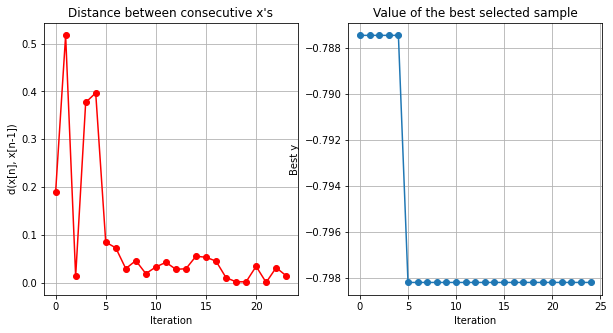

In [ ]:
#SVM classification - Matern52 + ExpQuad
kernel2 = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0) + GPy.kern.ExpQuad(input_dim=1,variance=1.0,lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=svm_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel2
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

optimizer.plot_convergence()

In [ ]:
SVM_car2 = svm.SVC(C=0.983,gamma=0.0948)
SVM_car2.fit(X_train,y_train)
y_pred = SVM_car2.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.815028901734104


In [34]:
#KNN Classification

#search domain
bounds = [ {'name': 'leaf_size', 'type': 'continuous', 'domain': (1, 100)},
        {'name': 'n_neighbors', 'type': 'discrete', 'domain': (3,4,5,6,7)}
      ]

knn1_leaf=[]
knn1_n=[]
knn1_score=[]

def knn_score(parameters):
  params = {
        'leaf_size': parameters[0][0],
        'n_neighbors':int(parameters[0][1])
    }
  
  clf = KNeighborsClassifier(leaf_size=params['leaf_size'],n_neighbors=params['n_neighbors'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)
  
  knn1_leaf.append(params['leaf_size'])
  knn1_n.append(params['n_neighbors'])
  knn1_score.append(score)

  return score

-0.9073760330578514
[81.21732888  7.        ]


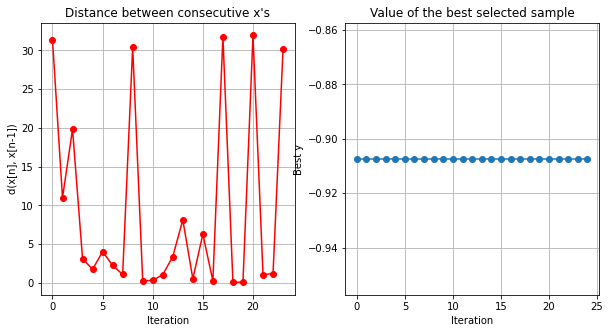

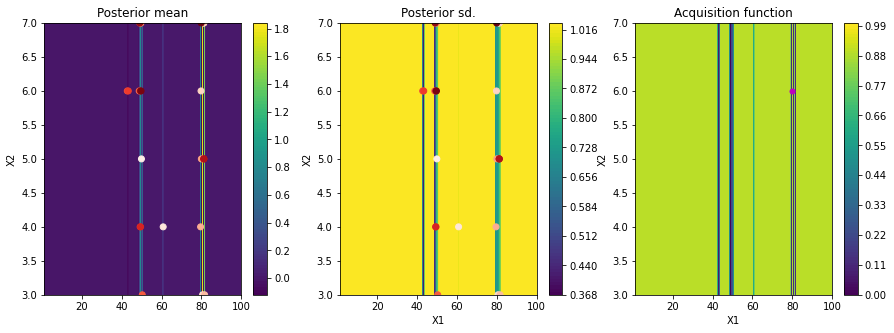

In [36]:
#KNN Classification - Matern52 kernel
kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=knn_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)
optimizer.plot_convergence()
optimizer.plot_acquisition()

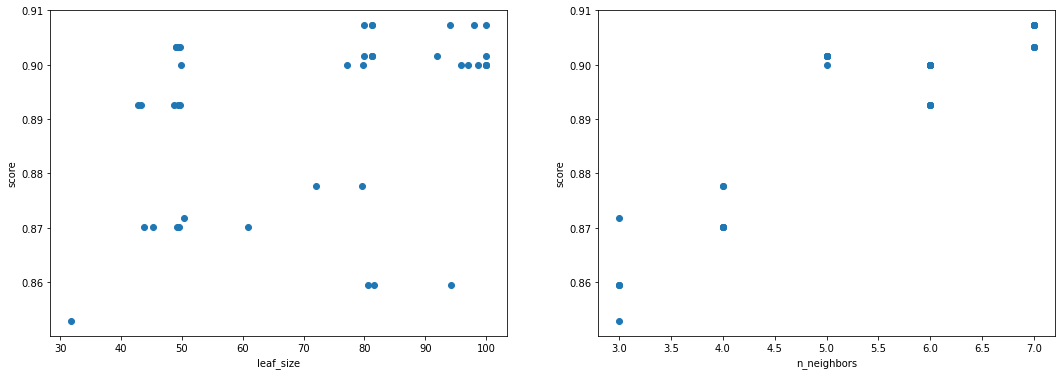

In [37]:
plot(knn1_leaf,knn1_n,knn1_score,'leaf_size','n_neighbors','score')

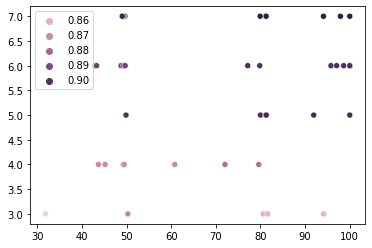

In [38]:
sns.scatterplot(x=knn1_leaf,y=knn1_n,hue=knn1_score)

In [ ]:
KNN_car1 = KNeighborsClassifier(leaf_size=44,n_neighbors=7)
KNN_car1.fit(X_train,y_train)
y_pred = KNN_car1.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9344894026974951


{'leaf_size': 29.69466048337127, 'n_neighbors': 3}
0.8528030303030304
{'leaf_size': 18.481083709248978, 'n_neighbors': 7}
0.8925137741046832
{'leaf_size': 32.711579780890176, 'n_neighbors': 7}
0.8925137741046832
{'leaf_size': 23.770782984205358, 'n_neighbors': 6}
0.9049035812672177
{'leaf_size': 32.45107702643483, 'n_neighbors': 7}
0.8925137741046832
{'leaf_size': 22.51857290704078, 'n_neighbors': 5}
0.8957988980716254
{'leaf_size': 25.08170476624961, 'n_neighbors': 5}
0.8957988980716254
{'leaf_size': 15.662510049749091, 'n_neighbors': 4}
0.8627203856749311
{'leaf_size': 44.95070308778467, 'n_neighbors': 7}
0.9032644628099173
{'leaf_size': 43.49333064686121, 'n_neighbors': 4}
0.8701446280991736
{'leaf_size': 45.82107094345026, 'n_neighbors': 3}
0.8718112947658403
{'leaf_size': 24.26787894381066, 'n_neighbors': 5}
0.8957988980716254
{'leaf_size': 23.306203963416493, 'n_neighbors': 4}
0.868526170798898
{'leaf_size': 23.939104381717733, 'n_neighbors': 4}
0.868526170798898
{'leaf_size': 23

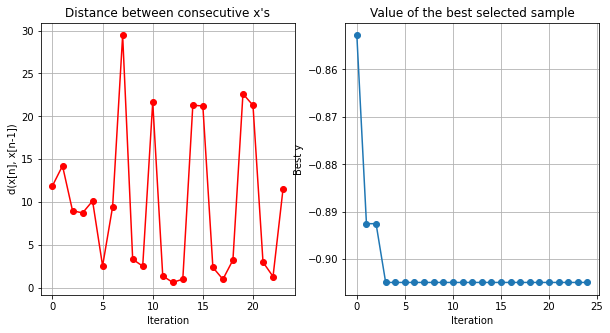

In [ ]:
#KNN Classification - Matern52 + ExpQuad
kernel2 = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0) + GPy.kern.ExpQuad(input_dim=1,variance=1.0,lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=knn_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel2
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)
optimizer.plot_convergence()

In [ ]:
KNN_car2 = KNeighborsClassifier(leaf_size=24,n_neighbors=6)
KNN_car2.fit(X_train,y_train)
y_pred = KNN_car2.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9171483622350675
